In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install category_encoders

In [ ]:
from category_encoders import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install xgboost

In [ ]:
import xgboost as xgb
xgb.__version__

'1.7.3'

In [ ]:
# Model and performance evaluation
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
lbl = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Crossroads/engg_data/crossroads_full_feature_set.csv")

In [ ]:
df.isnull().sum()

acct_id                           0
acct_type_desc                91418
event_name                        0
event_date                        0
plan_event_name              279172
comp_name                     80644
section_name                      0
row_name                          0
SeatNum                           0
price_code                        0
PC1                               0
Price                             0
paid                         154145
add_datetime                  80644
class_name                        0
status                            0
Sales_Source                1280704
isHost                            0
SeatType                          0
TicketClass                       0
Start Year                  1146325
LastYear                    1146325
Term                        1146445
TicketType                        0
SeatUniqueID                      0
Season                            0
ClubExpYear                 1146325
Tenure                      

In [ ]:
def pivot(train_data, group_cols, agg_col):
    data = train_data.groupby(group_cols).agg({agg_col: "count"}).reset_index()
    data = pd.pivot_table(data, values=agg_col, index=[group_cols[0]], columns=[group_cols[1]], aggfunc=np.sum).reset_index().rename_axis(None, axis=1)
    data = data.fillna(0)
    data["count"] = data["Yes"] + data["No"]
    data["%Attended"] = 100*data["Yes"]/(data["Yes"]+data["No"])
    return data

In [ ]:
accnt_type_df = pivot(df, ["acct_id", "isAttended"], "UniqueID")
accnt_type_df.head()

,acct_id,???,No,Yes,count,%Attended
0,190,6467.0,68700.0,369.0,69069.0,0.534248
1,14999990,0.0,8.0,0.0,8.0,0.000000
2,16999990,0.0,1.0,0.0,1.0,0.000000
3,110002390,14.0,29.0,97.0,126.0,76.984127
4,110003490,20.0,25.0,135.0,160.0,84.375000


In [ ]:
temp = df[df["isAttended"]!="???"]
acct_count_df = temp.groupby("acct_id").agg({"event_name": "nunique"}).reset_index()
acct_count_df = acct_count_df.rename(columns={"event_name": "event_name_count"})
acct_count_df.head()

,acct_id,event_name_count
0,190,18
1,14999990,2
2,16999990,1
3,110002390,18
4,110003490,16


In [ ]:
df = df.merge(accnt_type_df[["acct_id", "count", "%Attended"]], on="acct_id", how="left")
df = df.merge(acct_count_df[["acct_id", "event_name_count"]], on="acct_id", how="left")

In [ ]:
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,paid,add_datetime,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Start Year,LastYear,Term,TicketType,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Game Time,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,F,111.0,Y,2021-03-31 16:08:52,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,Yes,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,F,111.0,Y,2021-03-31 16:10:20,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,Yes,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,F,111.0,Y,2021-03-31 16:08:21,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0


In [ ]:
df.isnull().sum()["%Attended"]

13443

In [ ]:
t0 = df[(df["isAttended"]=="???") & (df["%Attended"]<21) & (df["count"]>=10) & (df["event_name_count"]>2)]
t0.shape, t0.acct_id.nunique()

((7128, 69), 96)

In [ ]:
t = df[df["isAttended"]=="???"]
t.shape, t.acct_id.nunique()

((128688, 69), 22102)

In [ ]:
100.0*7128/128688

5.538977993286087

In [ ]:
att  = df["isAttended"].values
df = df.drop("isAttended", 1)
df["isAttended"] = att

In [ ]:
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,paid,add_datetime,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Start Year,LastYear,Term,TicketType,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,Resold,ResalePrice,ResaleDate,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Game Time,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count,isAttended
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,F,111.0,Y,2021-03-31 16:08:52,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0,Yes
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,No
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,No
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,F,111.0,Y,2021-03-31 16:10:20,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0,Yes
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,F,111.0,Y,2021-03-31 16:08:21,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0,No


In [ ]:
df = df.drop(["acct_id", "event_date", "section_name", "row_name", "SeatNum", "Game Time", 
              "add_datetime", "Start Year", "LastYear", "SeatUniqueID", "ResaleDate", 
              "ClubExpYear"], 1)


In [ ]:
df["Season"] = df["Season"].astype(str)

In [ ]:
cat_cols = []
for k,v in dict(df.dtypes).items():
  if v=="object":
    cat_cols.append(k)

cat_cols = list(set(cat_cols) - set(["event_name", "UniqueID", "isAttended"]))

In [ ]:
# cat_cols

In [ ]:
from pandas.core.indexes import category
for col in cat_cols:
  df[col] = df[col].astype("category")

In [ ]:
def label_encode(row, col):
  if row[col]=="Yes":
    return 1
  elif row[col]=="No":
    return 0
  else:
    return row[col]

df["isAttended"] = df.apply(lambda x: label_encode(x, "isAttended"), 1)

In [ ]:
df.shape

(1286916, 57)

In [ ]:
df.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count,isAttended
0,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0,1
1,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,0
2,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,0
3,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0,1
4,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0,0


In [ ]:
train_df = df[df["isAttended"]!="???"]
test_df = df[df["isAttended"]=="???"]

In [ ]:
val_data = pd.read_csv("/content/drive/MyDrive/Crossroads/Ensemble_Model/Ensemble_Validation_DataSet_v1")
val_data = val_data.drop("Unnamed: 0", 1)
val_df = train_df[train_df["UniqueID"].isin(val_data["UniqueID"].values.tolist())]

In [ ]:
train_df = train_df[~train_df["UniqueID"].isin(val_df["UniqueID"].values.tolist())]

In [ ]:
train_cnt = train_df["count"].values
train_att = train_df["%Attended"].values
train_event_cnt = train_df["event_name_count"].values

val_cnt = val_df["count"].values
val_att = val_df["%Attended"].values
val_event_cnt = val_df["event_name_count"].values

test_cnt = test_df["count"].values
test_att = test_df["%Attended"].values
test_event_cnt = test_df["event_name_count"].values

In [ ]:
train_df = train_df.drop(["count"], 1)
val_df = val_df.drop(["count"], 1)
test_df = test_df.drop(["count"], 1)

In [ ]:
train_df.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,%Attended,event_name_count,isAttended
0,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,94.444444,18.0,1
1,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0,0
2,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0,0
3,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,83.333333,18.0,1
6,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,CLT21HOU-101-10-15,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.222222,18.0,0


In [ ]:
test_df["isAttended"].unique()

array(['???'], dtype=object)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((926582, 56), (231646, 56), (128688, 56))

In [ ]:
train_df["event_name"].nunique(), val_df["event_name"].nunique(), test_df["event_name"].nunique()

(18, 18, 2)

In [ ]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1].values
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1].values

In [ ]:
enc = TargetEncoder(cols=cat_cols, min_samples_leaf=20, smoothing=10, handle_missing = 'return_nan').fit(X_train, y_train)
X_train_encoded = enc.transform(X_train)
X_val_encoded = enc.transform(X_val)
X_test_encoded = enc.transform(X_test)

In [ ]:
X_train_encoded.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,%Attended,event_name_count
0,0.847217,CLT21HOU,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,94.444444,18.0
1,0.847217,CLT21HOU,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
2,0.847217,CLT21HOU,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
3,0.847217,CLT21HOU,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,83.333333,18.0
6,0.847217,CLT21HOU,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,32.0,CLT21HOU-101-10-15,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,72.222222,18.0


In [ ]:
train_ids = X_train["UniqueID"].values
val_ids = X_val["UniqueID"].values
test_ids = X_test["UniqueID"].values

X_train = X_train.drop(["UniqueID", "event_name"], 1)
X_val = X_val.drop(["UniqueID", "event_name"], 1)
X_test = X_test.drop(["UniqueID", "event_name"], 1)

In [ ]:
train_ids = X_train_encoded["UniqueID"].values
val_ids = X_val_encoded["UniqueID"].values
test_ids = X_test_encoded["UniqueID"].values

X_train_encoded = X_train_encoded.drop(["UniqueID", "event_name"], 1)
X_val_encoded = X_val_encoded.drop(["UniqueID", "event_name"], 1)
X_test_encoded = X_test_encoded.drop(["UniqueID", "event_name"], 1)

In [ ]:
X_train.head()

,acct_type_desc,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,%Attended,event_name_count
0,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,94.444444,18.0
1,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
2,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
3,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,83.333333,18.0
6,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.222222,18.0


In [ ]:
# Define the search space
param_grid = { 
    "max_depth": [4],
    "n_estimators": [200],
    "min_child_weight": [2],
    # # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3],
    # # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    # "scale_pos_weight": [1, 0.286, 3.502]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
df["isAttended"].value_counts()

1      900945
0      257283
???    128688
Name: isAttended, dtype: int64

In [ ]:
257283/900945, 900945/257283

(0.28557015134109187, 3.5017665372372058)

In [ ]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier(objective='binary:logistic', max_depth=4, n_estimators=200, min_child_weight=2, reg_alpha=0,
                        reg_lambda=0.5,
                        tree_method="gpu_hist", enable_categorical=True)
# Print default setting
xgboost.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': 0,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_encoded, [int(each) for each in y_train.tolist()])

# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

In [ ]:
# y_pred_val = grid_search.predict(X_val)

In [ ]:
y_pred_val = [each[1] for each in grid_search.predict_proba(X_val)]
y_pred_val = [1 if each>0.5 else 0 for each in y_pred_val]

print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))

In [ ]:
y_pred_val = [each[1] for each in grid_search.predict_proba(X_val)]
y_pred_val = [1 if each>0.55 else 0 for each in y_pred_val]

print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))

In [ ]:
ft_importance = pd.DataFrame({'feature':X_val.columns, 'importance':grid_search.best_estimator_.feature_importances_})

In [ ]:
ft_importance.sort_values(by=['importance'],ascending=False).to_csv('Feature Importance.csv')

In [ ]:
grid_search.best_estimator_.feature_importances_

In [ ]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

In [ ]:
X_train_encoded.head()

,acct_type_desc,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,%Attended,event_name_count
0,0.847217,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,25.0,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,94.444444,18.0
1,0.847217,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,20.0,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
2,0.847217,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,20.0,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,70.833333,18.0
3,0.847217,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,4.0,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,83.333333,18.0
6,0.847217,0.831096,0.841971,0.856563,0.846325,111.0,0.83152,0.828021,0.841971,NaN,0,0.773091,0.799824,NaN,0.848955,0.752518,32.0,NaN,NaN,NaN,0.845861,0.833541,0.801652,0.78405,0.814664,0.754976,0.840094,0.841979,0.833354,0.833235,0.797324,0.843415,199.4,NaN,NaN,1.0,0.67198,0.684206,0.677035,0.680039,0.817374,6,0.782799,108,89,2.5,184.4,52.12,0.0,39.62,1,72.222222,18.0


In [ ]:
xgboost.fit(X_train_encoded, [int(each) for each in y_train.tolist()], 
            eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)], 
            verbose=2, early_stopping_rounds=30)

[0]	validation_0-logloss:0.53799	validation_1-logloss:0.53794
[2]	validation_0-logloss:0.40330	validation_1-logloss:0.40322
[4]	validation_0-logloss:0.35081	validation_1-logloss:0.35063
[6]	validation_0-logloss:0.32798	validation_1-logloss:0.32769
[8]	validation_0-logloss:0.31778	validation_1-logloss:0.31749
[10]	validation_0-logloss:0.31278	validation_1-logloss:0.31243
[12]	validation_0-logloss:0.31039	validation_1-logloss:0.31000
[14]	validation_0-logloss:0.30900	validation_1-logloss:0.30858
[16]	validation_0-logloss:0.30786	validation_1-logloss:0.30743
[18]	validation_0-logloss:0.30730	validation_1-logloss:0.30686
[20]	validation_0-logloss:0.30680	validation_1-logloss:0.30634
[22]	validation_0-logloss:0.30640	validation_1-logloss:0.30592
[24]	validation_0-logloss:0.30566	validation_1-logloss:0.30526
[26]	validation_0-logloss:0.30525	validation_1-logloss:0.30488
[28]	validation_0-logloss:0.30505	validation_1-logloss:0.30470
[30]	validation_0-logloss:0.30478	validation_1-logloss:0.304

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
xgboost.feature_importances_.shape, X_train_encoded.columns.shape

((53,), (53,))

In [ ]:
ft_weights = xgboost.feature_importances_
cols = X_train_encoded.columns
imp_df = pd.DataFrame()
imp_df["Feature"] = cols
imp_df["Importance"] = ft_weights
sum_ = imp_df["Importance"].sum()
def get_imp_perc(row):
  return round(100.0*row["Importance"] / sum_, 2)

imp_df["Importance%"] = imp_df.apply(lambda x: get_imp_perc(x), 1)
imp_df = imp_df.sort_values("Importance%", ascending=False).reset_index(drop=True)

In [ ]:
imp_df

,Feature,Importance,Importance%
0,Game_Type,0.331003,33.10
1,%Attended,0.291305,29.13
2,Resold,0.069833,6.98
3,seat_segment,0.049183,4.92
4,section_group_segment,0.032492,3.25
5,Week,0.028967,2.90
6,unemployment_rate,0.027477,2.75
7,row_segment,0.017684,1.77
8,Home Points,0.014380,1.44
9,TicketType,0.009363,0.94


In [ ]:
y_pred_val_logit = [each[1] for each in xgboost.predict_proba(X_val_encoded)]

In [ ]:
y_pred_val = [1 if each>0.5 else 0 for each in y_pred_val_logit]

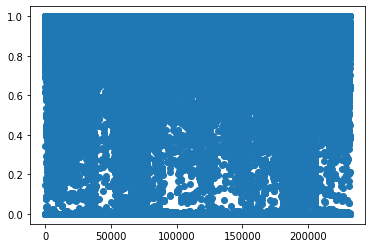

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([x for x in range(len(y_pred_val_logit))], y_pred_val_logit)

In [ ]:
print(confusion_matrix([int(each) for each in y_val.tolist()], y_pred_val))

[[ 28608  22849]
 [  5219 174970]]


In [ ]:
print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))

In [ ]:
val_sub_df = pd.DataFrame()
val_sub_df["UniqueID"] = val_ids
val_sub_df["XGB_model_preds"] = y_pred_val_logit

In [ ]:
val_sub_df.head()

,UniqueID,XGB_model_preds
0,CLT21HOU-101-10-13,0.753008
1,CLT21HOU-101-10-14,0.753008
2,CLT21HOU-101-10-17,0.970537
3,CLT21HOU-101-10-5,0.962344
4,CLT21HOU-101-10-6,0.836404


In [ ]:
val_sub_df.to_csv("/content/drive/MyDrive/Crossroads/Ensemble_Model/saved_preds/Ayan_XGB_v1.3_TE_Acc_ID_val_preds.csv", index=False)


In [ ]:
test_preds_logit = [each[1] for each in xgboost.predict_proba(X_test_encoded)]

In [ ]:
test_preds = [1 if each>0.5 else 0 for each in test_preds_logit]

In [ ]:
1 - (sum(test_preds)/len(test_preds))

0.08151498197190099

In [ ]:
len(test_preds) - sum(test_preds), len(test_preds)

(10490, 128688)

In [ ]:
test_sub_df = pd.DataFrame()
test_sub_df["UniqueID"] = test_ids
test_sub_df["XGB_model_preds"] = test_preds_logit

In [ ]:
test_sub_df.to_csv("/content/drive/MyDrive/Crossroads/Ensemble_Model/saved_preds/Ayan_XGB_v1.3_TE_Acc_ID__test_preds.csv", index=False)
